# Ion–Particle Coagulation

This notebook investigates the coagulation of positively charged aerosol particles (0 to 11 elementary charges) with negatively charged ions. Specifically, we analyze collisions between a **3 nm radius particle** and a **0.45 nm radius ion** under various coagulation models.

### **Coagulation Kernels**
To model ion–particle interactions, we compare several coagulation kernels, each incorporating different physical effects:

- **Hard Sphere Kernel:** Assumes Brownian collisions with idealized electrostatic interactions.
- **Dyachkov et al. (2007) Kernel** – [J. Chem. Phys., 126, 094501](https://aip.scitation.org/doi/10.1063/1.2713719)
- **Gatti & Kortshagen (2008) Kernel** – [Phys. Rev. E, 78, 046402](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.78.046402)
- **Gopalakrishnan et al. (2012) Kernel** – [Phys. Rev. E, 85, 026410](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.85.026410)
- **Chahl et al. (2019) Kernel** – [Aerosol Sci. Technol., 53(8), 877-892](https://www.tandfonline.com/doi/full/10.1080/02786826.2019.1614522)

Each kernel accounts for charge-dependent coagulation efficiencies. This study aims to compare these models to evaluate how charge influences ion–particle collision rates.

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# from particula.util.lf2013_coagulation import lf2013_coag_full
import particula as par

## Setup

This block is setting up the properties of a set of aerosol particles, calculating key parameters related to their movement and interaction within a gaseous environment, and determining their diffusion behavior.

### **1. Environmental Setup**
- The temperature is set to **278.0 K**, which will be used for further calculations.

### **2. Particle Properties**
- **Particle Radius:** A set of particles is defined with radii ranging from **0.45 nm to 3 nm**.
- **Charge:** The particles have a range of electric charges from **-1 to +12**.
- **Density:** The particle density is primarily set to **1700 kg/m³**, with one particle (ion) at **1860 kg/m³**.

### **3. Mass Calculation**
- Using the formula for the volume of a sphere and the given densities, the **mass of each particle** is computed.

### **4. Gas Properties**
- The **dynamic viscosity** of the surrounding gas is obtained using the `par.gas.get_dynamic_viscosity()` function.

### **5. Knudsen Number Calculation**
- The **Knudsen number**, which determines whether the particle behavior is in the free molecular, transition, or continuum regime, is computed using:
  - The **mean free path** of gas molecules (from `par.gas.get_molecule_mean_free_path()`).
  - The particle radius.

### **6. Friction Factor**
- The **friction factor**, which influences the motion and diffusion of the particles, is calculated using:
  - Particle radius
  - Dynamic viscosity
  - Slip correction factor (using `par.particles.get_cunningham_slip_correction()`).

### **7. Coulomb Enhancement Ratio**
- The **Coulomb potential ratio**, which determines how electrostatic forces influence particle interactions, is computed using:
  - Particle radius
  - Charge
  - Temperature

### **8. Diffusive Knudsen Number**
- Finally, the **diffusive Knudsen number**, which governs diffusion behavior, is computed using:
  - Particle radius
  - Particle mass
  - Friction factor
  - Coulomb potential ratio
  - Temperature


In [3]:
# environment
temperature = 278.0
pressure = 101325.0

# get each particle properties
particle_radius = np.array(
    [
        0.45e-9,
        3e-9,
        3e-9,
        3e-9,
        3e-9,
        3e-9,
        3e-9,
        3e-9,
        3e-9,
        3e-9,
        3e-9,
        3e-9,
        3e-9,
    ]
)
charge = np.array([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
particle_density = np.array(
    [
        1860,
        1700,
        1700,
        1700,
        1700,
        1700,
        1700,
        1700,
        1700,
        1700,
        1700,
        1700,
        1700,
    ]
)

# calculate mass
particle_mass = 4 / 3 * np.pi * particle_radius**3 * particle_density

# get properties
dynamic_viscosity = par.gas.get_dynamic_viscosity(temperature=temperature)

# get knudsen number
knudsen_number = par.particles.get_knudsen_number(
    mean_free_path=par.gas.get_molecule_mean_free_path(
        temperature=temperature,
        dynamic_viscosity=dynamic_viscosity,
        pressure=pressure,
    ),
    particle_radius=particle_radius,
)
# get friction factor
friction_factor = par.particles.get_friction_factor(
    particle_radius=particle_radius,
    dynamic_viscosity=par.gas.get_dynamic_viscosity(temperature=temperature),
    slip_correction=par.particles.get_cunningham_slip_correction(
        knudsen_number=knudsen_number
    ),
)

# get coulomb potential ratio
coulomb_potential_ratio = par.particles.get_coulomb_enhancement_ratio(
    particle_radius=particle_radius,
    charge=charge,
    temperature=temperature,
)

# get diffusive knudsen number
diffusive_knudsen = par.particles.get_diffusive_knudsen_number(
    particle_radius=particle_radius,
    particle_mass=particle_mass,
    friction_factor=friction_factor,
    coulomb_potential_ratio=coulomb_potential_ratio,
    temperature=temperature,
)

## Dimensionless Kernel

These kernels are used in aerosol dynamics to quantify the frequency at which particles of different sizes collide and coagulate.

### **Types of Kernels**
1. **Hard-Sphere Dimensionless Kernel (`get_hard_sphere_kernel`)**
   - Represents the baseline collision frequency assuming hard-sphere interactions.
   - Accounts for the Brownian motion of particles and their idealized electrostatic interactions.

2. **Coulomb Dimensionless Kernels**
   - These extend the hard-sphere kernel by incorporating parameterized (non-ideal) electrostatic interactions.
   - Used to model particle coagulation in charged aerosol systems.

   The different Coulomb kernels included are:
   - `get_coulomb_kernel_dyachkov2007`: Based on Dyachkov et al. (2007), suitable for small Knudsen number scenarios.
   - `get_coulomb_kernel_gatti2008`: Developed by Gatti et al. (2008), useful for intermediate Knudsen regimes.
   - `get_coulomb_kernel_gopalakrishnan2012`: From Gopalakrishnan et al. (2012), used for describing charge-dominated coagulation.
   - `get_coulomb_kernel_chahl2019`: Derived from Chahl et al. (2019), relevant for advanced charge-driven aggregation modeling.

#### **Parameters Used**
- `diffusive_knudsen`: The **diffusive Knudsen number**, which defines whether the particles are in the free molecular or continuum regime, accounting for electrostatic interactions.
- `coulomb_potential_ratio`: A dimensionless parameter describing the ratio of Coulombic forces to thermal energy, determining the effect of electrostatic interactions.


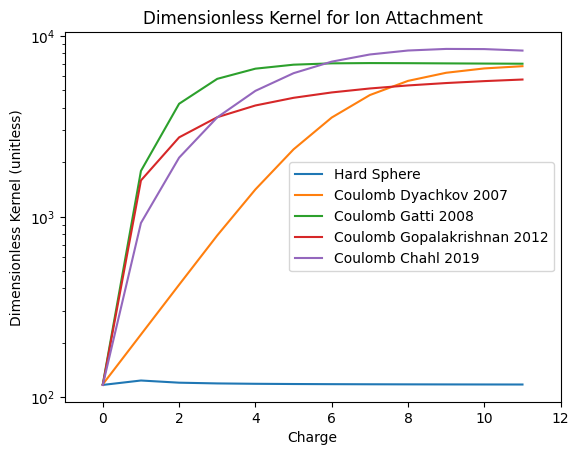

In [4]:
# hard sphere dimensionless kernel
hard_sphere_dimensionless_kernel = par.dynamics.get_hard_sphere_kernel(
    diffusive_knudsen=diffusive_knudsen,
)
# coulomb dimensionless kernel for Dyachkov et al. (2007)
coulomb_dyachkov2007_dimensionless_kernel = (
    par.dynamics.get_coulomb_kernel_dyachkov2007(
        diffusive_knudsen=diffusive_knudsen,
        coulomb_potential_ratio=coulomb_potential_ratio,
    )
)

# coulomb dimensionless kernel for Gatti et al. (2008)
coulomb_gatti2008_dimensionless_kernel = (
    par.dynamics.get_coulomb_kernel_gatti2008(
        diffusive_knudsen=diffusive_knudsen,
        coulomb_potential_ratio=coulomb_potential_ratio,
    )
)

# coulomb dimensionless kernel for Gopalakrishnan et al. (2012)
coulomb_g2012_dimensionless_kernel = (
    par.dynamics.get_coulomb_kernel_gopalakrishnan2012(
        diffusive_knudsen=diffusive_knudsen,
        coulomb_potential_ratio=coulomb_potential_ratio,
    )
)

# coulomb dimensionless kernel for Chahl et al. (2019)
coulomb_chahl20019_dimensionless_kernel = (
    par.dynamics.get_coulomb_kernel_chahl2019(
        diffusive_knudsen=diffusive_knudsen,
        coulomb_potential_ratio=coulomb_potential_ratio,
    )
)

# plot the first index ion attachment to the other particles
fig, ax = plt.subplots()
ax.plot(
    charge[1:], hard_sphere_dimensionless_kernel[0, 1:], label="Hard Sphere"
)
ax.plot(
    charge[1:],
    coulomb_dyachkov2007_dimensionless_kernel[0, 1:],
    label="Coulomb Dyachkov 2007",
)
ax.plot(
    charge[1:],
    coulomb_gatti2008_dimensionless_kernel[0, 1:],
    label="Coulomb Gatti 2008",
)
ax.plot(
    charge[1:],
    coulomb_g2012_dimensionless_kernel[0, 1:],
    label="Coulomb Gopalakrishnan 2012",
)
ax.plot(
    charge[1:],
    coulomb_chahl20019_dimensionless_kernel[0, 1:],
    label="Coulomb Chahl 2019",
)
ax.set_yscale("log")
ax.set_xlim(-1, 12)
ax.set_xlabel("Charge")
ax.set_ylabel("Dimensionless Kernel (unitless)")
ax.set_title("Dimensionless Kernel for Ion Attachment")
ax.legend()
plt.show()

## Dimensional Kernel

The code below transforms **dimensionless coagulation kernels** into **dimensional kernels** using the `get_dimensional_kernel` function from the `Particula` library. This transformation is necessary because dimensionless kernels provide normalized interaction rates that need to be rescaled to physical units for real-world applications.

The function `get_dimensional_kernel` requires several physical parameters to properly scale the dimensionless kernel:

1. **Sum of Particle Radii (`sum_of_radii`)**
   ```python
   sum_of_radii = particle_radius[:, np.newaxis] + particle_radius[np.newaxis, :]
   ```
   - This computes a 2D array where each entry represents the sum of the radii of two interacting particles.
   - The broadcasting ensures that each pairwise combination of particle sizes is considered.

2. **Reduced Mass (`reduced_mass`)**
   - The **reduced mass** is a standard concept in two-body problems, defined as:
     μ = {m_1 m_2}/{m_1 + m_2}
   - This accounts for how mass differences influence the dynamics of collisions.

3. **Reduced Friction Factor (`reduced_friction_factor`)**
   ```python
   reduced_friction_factor = par.util.get_reduced_self_broadcast(friction_factor)
   ```
   - The **friction factor** relates to the drag experienced by particles in a medium.
   - Using a reduced version ensures that the calculation remains valid for all possible particle pairings.

4. **Applying Scaling to Compute Dimensional Kernel**
   Each dimensional kernel is computed by combining:
   - The precomputed **dimensionless kernel**
   - The **coulomb potential ratio**, which determines the electrostatic influence.
   - The **sum of radii, reduced mass, and reduced friction factor**, which introduce physical units.

The transition from dimensionless to dimensional kernels is required to:
- Convert relative interaction rates into absolute coagulation frequencies (e.g., collisions per second per cubic meter).


## Kernel via System State

The shortest method to get the kernel is via `par.dynamics.get_coulomb_kernel_dyachkov2007_via_system_state`. This function combines the steps above into a single call, allowing for a more streamlined approach to obtaining the kernel.

However, depending on you program the properties calculated above may already be available. In this case, you can use the `par.dynamics.get_coulomb_kernel_dyachkov2007` function to reduce duplicate calculations.


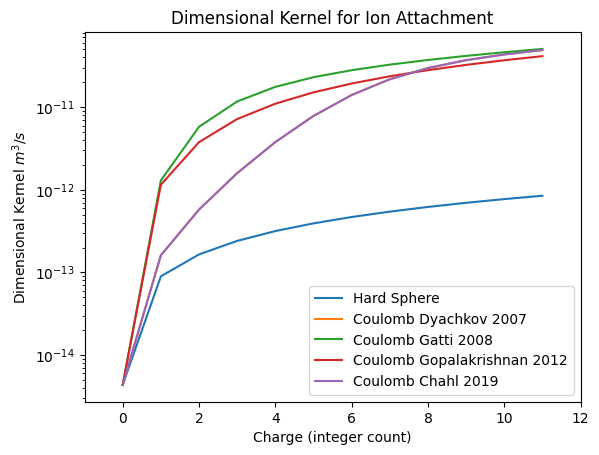

In [6]:
sum_of_radii = particle_radius[:, np.newaxis] + particle_radius[np.newaxis, :]
reduced_mass = par.util.get_reduced_self_broadcast(particle_mass)
reduced_friction_factor = par.util.get_reduced_self_broadcast(friction_factor)

# hard sphere dimensional kernel
hard_sphere_dimensional_kernel = par.dynamics.get_dimensional_kernel(
    dimensionless_kernel=hard_sphere_dimensionless_kernel,
    coulomb_potential_ratio=coulomb_potential_ratio,
    sum_of_radii=sum_of_radii,
    reduced_mass=reduced_mass,
    reduced_friction_factor=reduced_friction_factor,
)

# coulomb dimensional kernel for Dyachkov et al. (2007)
coulomb_dyachkov2007_dimensional_kernel = par.dynamics.get_dimensional_kernel(
    dimensionless_kernel=coulomb_dyachkov2007_dimensionless_kernel,
    coulomb_potential_ratio=coulomb_potential_ratio,
    sum_of_radii=sum_of_radii,
    reduced_mass=reduced_mass,
    reduced_friction_factor=reduced_friction_factor,
)

# coulomb dimensional kernel for Gatti et al. (2008)
coulomb_gatti2008_dimensional_kernel = par.dynamics.get_dimensional_kernel(
    dimensionless_kernel=coulomb_gatti2008_dimensionless_kernel,
    coulomb_potential_ratio=coulomb_potential_ratio,
    sum_of_radii=sum_of_radii,
    reduced_mass=reduced_mass,
    reduced_friction_factor=reduced_friction_factor,
)

# coulomb dimensional kernel for Gopalakrishnan et al. (2012)
coulomb_g2012_dimensional_kernel = par.dynamics.get_dimensional_kernel(
    dimensionless_kernel=coulomb_g2012_dimensionless_kernel,
    coulomb_potential_ratio=coulomb_potential_ratio,
    sum_of_radii=sum_of_radii,
    reduced_mass=reduced_mass,
    reduced_friction_factor=reduced_friction_factor,
)

# coulomb dimensional kernel for Chahl et al. (2019) via system state
coulomb_chahl20019_dimensional_kernel = par.dynamics.get_coulomb_kernel_dyachkov2007_via_system_state(
    particle_radius=particle_radius,
    particle_mass=particle_mass,
    particle_charge=charge,
    temperature=temperature,
    pressure=pressure,
)

# plot the first index ion attachment to the other particles
fig, ax = plt.subplots()
ax.plot(charge[1:], hard_sphere_dimensional_kernel[0, 1:], label="Hard Sphere")
ax.plot(
    charge[1:],
    coulomb_dyachkov2007_dimensional_kernel[0, 1:],
    label="Coulomb Dyachkov 2007",
)
ax.plot(
    charge[1:],
    coulomb_gatti2008_dimensional_kernel[0, 1:],
    label="Coulomb Gatti 2008",
)
ax.plot(
    charge[1:],
    coulomb_g2012_dimensional_kernel[0, 1:],
    label="Coulomb Gopalakrishnan 2012",
)
ax.plot(
    charge[1:],
    coulomb_chahl20019_dimensional_kernel[0, 1:],
    label="Coulomb Chahl 2019",
)
ax.set_yscale("log")
ax.set_xlim(-1, 12)
ax.set_xlabel("Charge (integer count)")
ax.set_ylabel(r"Dimensional Kernel $m^3/s$")
ax.set_title("Dimensional Kernel for Ion Attachment")
ax.legend(loc="lower right")
plt.show()

## Conclusion

In this notebook, we explored the ion-particle coagulation process by calculating various dimensionless and dimensional kernels for different coagulation approximations. The key steps and findings are summarized below:

1. **Environmental and Particle Properties Setup:**
    - Temperature: 278.0 K
    - Particle radii ranged from 0.45 nm to 3 nm.
    - Charges ranged from -1 to +12.
    - Particle densities were set to 1700 kg/m³ and 1860 kg/m³.

2. **Key Calculations:**
    - **Mass Calculation:** Using the volume of a sphere and given densities.
    - **Dynamic Viscosity:** Obtained using the `par.gas.get_dynamic_viscosity()` function.
    - **Knudsen Number:** Calculated using the mean free path and particle radius.
    - **Friction Factor:** Influences the motion and diffusion of particles.
    - **Coulomb Potential Ratio:** Determines the effect of electrostatic interactions.
    - **Diffusive Knudsen Number:** Governs diffusion behavior.

3. **Dimensionless Kernels:**
    - Hard-Sphere Kernel: Represents baseline collision frequency with idealized electrostatic interactions.
    - Coulomb Kernels: Incorporate electrostatic interactions for different parameterization (Dyachkov 2007, Gatti 2008, Gopalakrishnan 2012, Chahl 2019).

4. **Dimensional Kernels:**
    - Transformed dimensionless kernels into dimensional kernels using physical parameters.
    - Plotted the dimensional kernels for ion attachment to other particles.

The analysis provided insights into how different coagulation approximations affect the collision frequencies and coagulation rates of charged particles. The results can be used to better understand and model aerosol dynamics in various environmental and industrial applications.